In [1]:
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import partial_dependence 


%matplotlib inline

In [2]:
# function to convert datetime object to 4 - for force ONLY
def datetime(df, col_as_str):
    yearmonthday = df[col_as_str].astype(str).str.split(" ")
    ymd = yearmonthday.apply(lambda x: x[0]).str.split("/")
    year = ymd.apply(lambda x: x[2])
    month = ymd.apply(lambda x: x[0])
    day = ymd.apply(lambda x: x[1])
    time = ymd = yearmonthday.apply(lambda x: x[1]+x[2]).astype(str)
    df["year"] = year
    df["month"] = month
    df["day"] = day
    df["time"] = time
    # apply(lambda x: pd.to_datetime(x, format="%H%M"))
    return df

In [191]:
force = pd.read_csv("data/Use_Of_Force.csv")

In [192]:
force = datetime(force,"Occured_date_time" )
foo = pd.to_datetime( force.Occured_date_time )
epoch_second = foo.map(lambda x:x.value/1e9)
force["epoch"] = epoch_second

force["day_of_week"] = foo.dt.dayofweek

In [193]:
# Function to convert the date format 
def convert24(str1): 
    
    
      
    # Checking if last two elements of time 
    # is AM and first two elements are 12 
    if str1[-2:] == "AM" and str1[:2] == "12": 
        return (int("00" + str1[3:5])/100)
          
    # remove the AM     
    elif str1[-2:] == "AM": 
        return (int(str1[:2] + str1[3:5])/100)
      
    # Checking if last two elements of time 
    # is PM and first two elements are 12    
    elif str1[-2:] == "PM" and str1[:2] == "12": 
        return (int(str1[:2] + str1[3:5])/100)
          
    else: 
          
        # add 12 to hours and remove PM 
        return (int(str(int(str1[:2]) + 12) + str1[3:5])/100)

In [194]:
force["time"] = force["time"].apply(lambda x: convert24(x))


In [195]:
force.groupby(["Incident_Type", "Subject_Race", "Subject_Gender"])["Precinct"].count()

Incident_Type           Subject_Race                   Subject_Gender
Level 1 - Use of Force  American Indian/Alaska Native  Female              32
                                                       Male                38
                        Asian                          Female              78
                                                       Male               200
                                                       Not Specified        1
                        Black or African American      Female             499
                                                       Male              1964
                                                       Not Specified        3
                        Hispanic or Latino             Female              22
                                                       Male               304
                                                       Not Specified        1
                        Nat Hawaiian/Oth Pac Islander  Female           

In [196]:
force.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9838 entries, 0 to 9837
Data columns (total 17 columns):
ID                   9838 non-null object
Incident_Num         9838 non-null int64
Incident_Type        9838 non-null object
Occured_date_time    9838 non-null object
Precinct             9838 non-null object
Sector               9838 non-null object
Beat                 9838 non-null object
Officer_ID           9838 non-null int64
Subject_ID           9838 non-null int64
Subject_Race         9838 non-null object
Subject_Gender       9838 non-null object
year                 9838 non-null object
month                9838 non-null object
day                  9838 non-null object
time                 9838 non-null float64
epoch                9838 non-null float64
day_of_week          9838 non-null int64
dtypes: float64(2), int64(4), object(11)
memory usage: 1.3+ MB


In [197]:
len(force.Incident_Type.value_counts()), len(force.year.value_counts()), len(force.month.value_counts()), len(force)


(4, 6, 12, 9838)

In [198]:
force.Incident_Type.value_counts()

Level 1 - Use of Force    7474
Level 2 - Use of Force    2185
Level 3 - Use of Force     105
Level 3 - OIS               74
Name: Incident_Type, dtype: int64

In [199]:
force1 = force[force["Incident_Type"] == "Level 1 - Use of Force"]
force2 = force[force["Incident_Type"] == "Level 2 - Use of Force"]
force3 = force[force["Incident_Type"] == "Level 3 - Use of Force"]
forceOIS = force[force["Incident_Type"] == "Level 3 - OIS"]

In [200]:
f1b = force1.Beat.value_counts()
f2b = force2.Beat.value_counts()
f3b = force3.Beat.value_counts()
fOISb = forceOIS.Beat.value_counts()
force_beats = pd.DataFrame({"force1":f1b, "force2":f2b, "force3": f3b,"forceOIS": fOISb})

In [201]:
force_beats.fillna(0, inplace=True)


In [202]:
force.time.head()

0     1.40
1     4.15
2    18.58
3    13.19
4    23.04
Name: time, dtype: float64

In [203]:
y = 4
ys = categorize_time(y)
type(ys), type(y)

(int, int)

In [204]:
def categorize_time(x):
    if 18<=x<21:
        x = 18
    elif 21<=x <23.59:
        x = 21
    elif 0<=x < 3:
        x = 0
    elif 3<= x < 6:
        x = 3
    elif 6<= x <9:
        x = 6
    elif 9<= x < 12:
        x = 9
    elif 12<= x <15:
        x = 12
    elif 15<= x < 18:
        x = 15
    return x

In [205]:
force["time"] = force["time"].apply(lambda x: categorize_time(x))

In [152]:
X = force[["month", "day", "day_of_week", "time", "Subject_Race", "Subject_Gender", "Precinct", "Sector", "Beat"]]
y = force["Incident_Type"]



In [122]:
X.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9838 entries, 0 to 9837
Data columns (total 5 columns):
Subject_Race      9838 non-null object
Subject_Gender    9838 non-null object
Precinct          9838 non-null object
Sector            9838 non-null object
Beat              9838 non-null object
dtypes: object(5)
memory usage: 384.4+ KB


In [153]:
# makes more sense to use all the data - bc time of year could change the outcome as well

enc = OneHotEncoder()

In [155]:
enc.fit(X)

OneHotEncoder(categorical_features=None, categories=None, drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='error',
              n_values=None, sparse=True)

In [156]:
XT = enc.transform(X)

In [127]:
type(XT)

scipy.sparse.csr.csr_matrix

In [157]:
data = XT.data

In [129]:
XT.shape, y.shape

((9838, 91), (9838,))

In [158]:
X_train, X_test, y_train, y_test = train_test_split(XT, y, test_size=0.2, random_state=659)

In [159]:
rdf = RandomForestClassifier(oob_score=True, random_state=659)

In [160]:
rdf.fit(X_train, y_train)

/Users/sarahburgart/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/sarahburgart/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/sarahburgart/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/sarahburgart/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=True, random_state=659, verbose=0,
                       warm_start=False)

In [133]:
yhat = rdf.predict(X_test)

In [161]:
rdf.score(X_test, y_test)

0.8556910569105691

In [164]:
indices = np.argsort(rdf.feature_importances_)
inds = indices[-10:]


In [165]:
arrs = []
for arr in enc.categories_:
    for col in arr:
        arrs.append(col)
   

In [166]:

for idx in inds:
    print(arrs[idx])


0
05
4
Female
2
Male
6
3
Black or African American
White


In [53]:
X = pd.get_dummies(data = X, 
                     columns=["Subject_Gender", "Subject_Race", 
                             "Precinct", "Sector", "Beat"], 
                     prefix=["Subject_Gender", "Subject_Race", 
                             "Precinct", "Sector", "Beat"])

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=659)

In [55]:
rf = RandomForestClassifier(oob_score=True, random_state=659)

In [56]:
rf.fit(X_train, y_train)

/Users/sarahburgart/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/sarahburgart/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/sarahburgart/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/sarahburgart/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=True, random_state=659, verbose=0,
                       warm_start=False)

In [57]:
rf.score(X_test, y_test)

0.8648373983739838

In [142]:
# most important features
indices = np.argsort(rf.feature_importances_)
big = indices[-10:]
cols = X.columns
cols[big]

IndexError: index 15 is out of bounds for axis 0 with size 5

In [59]:
sorted(rf.feature_importances_)[-10:]

[0.009074258700210088,
 0.01069906746826961,
 0.015328404396293705,
 0.01665047999728756,
 0.02045204033510796,
 0.023434961506206085,
 0.11285092024719348,
 0.13272988780083372,
 0.17100353196302862,
 0.25109350909943956]

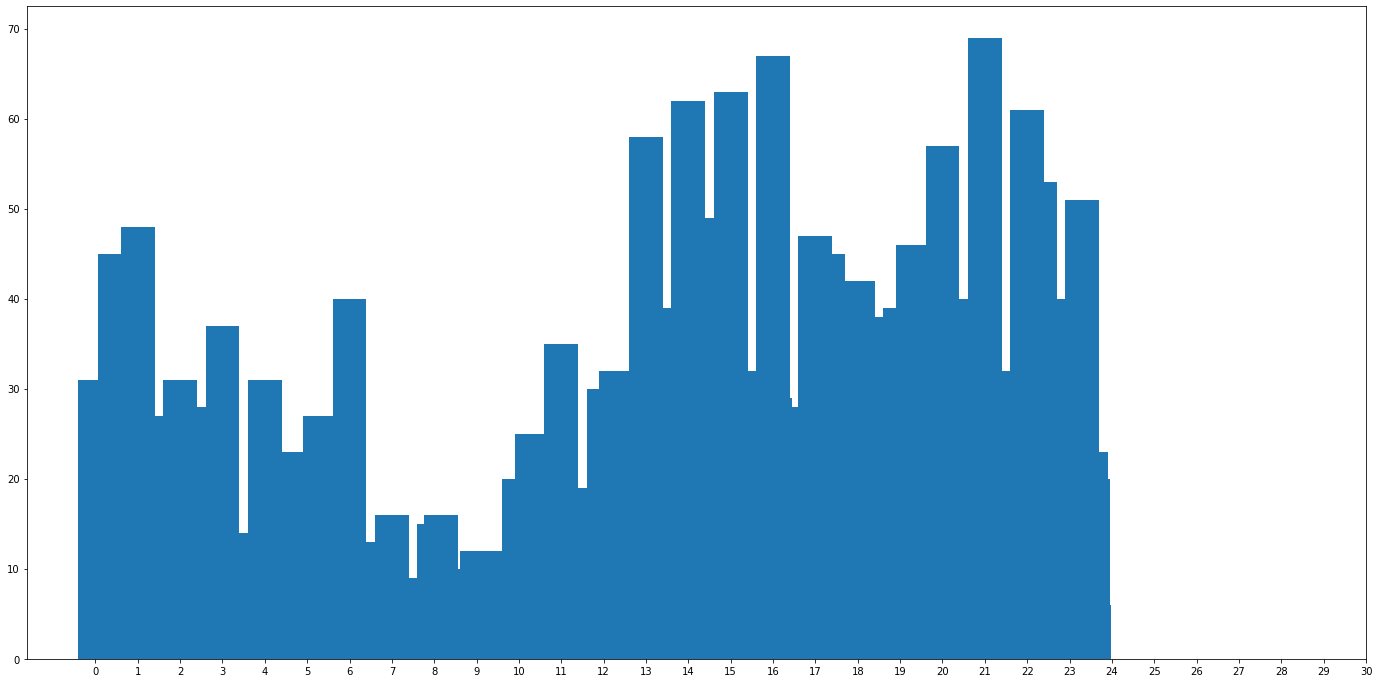

In [100]:
t = X.time.value_counts()

fig, axs = plt.subplots(1,1,figsize=(24,12))
axs.bar(t.index, t);
axs.set_xticks(np.arange(31));

In [99]:
X.day.value_counts()

01    495
20    393
06    380
27    368
19    367
23    362
28    349
13    349
25    347
02    333
07    328
11    324
18    324
22    317
21    316
16    312
26    309
08    302
30    296
05    296
15    295
03    294
14    294
10    289
29    275
04    269
17    267
09    266
12    262
24    251
31    209
Name: day, dtype: int64

In [62]:
ts = t.sort_index()
len(ts)

1328

In [66]:
tsc = pd.cut(ts, 24, retbins=True)
#tsc

#write a function to group


In [64]:
# # Group the data by the index's hour value, then aggregate by the average
series.groupby(series.index.hour).mean()

# or round down

NameError: name 'series' is not defined

In [67]:
t = X.time.value_counts()

AttributeError: 'DataFrame' object has no attribute 'Subject_Race'